
ANALISI CONDOTTA CON LA FEATURE error (PASSATA A BOOLEAN OUTCOME)

In [1]:
from preprocessing_compas import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare,encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
import torch

from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor
    

In [2]:
# Carica il CSV
df = pd.read_csv("cox-violent-parsed.csv")

In [3]:
torch.manual_seed(42)
seed = 42
pd.options.display.float_format = '{:.3f}'.format

In [4]:
pruning = 0.00
epsilon = pruning
min_sup = 0.15
percentage = 30

In [5]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) 
print(f"VALIDATION SET ROWS: ", df_val.shape[0])
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  10975
VALIDATION SET ROWS:  2439
HOLDOUT SET ROWS:  2440
TEST SET ROWS:  2439


In [6]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) 
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) 
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  10975
VALIDATION SET ROWS:  2439
HOLDOUT SET ROWS:  2440
TEST SET ROWS:  2439


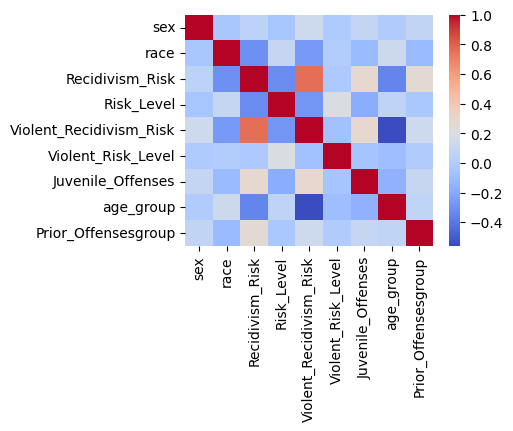

In [7]:
df_train_no_Violent_Recidivist = df_train_enc.drop(columns = 'Violent_Recidivist')
plt.figure(figsize=(4, 3))
g = sns.heatmap(df_train_no_Violent_Recidivist.corr(),
                annot = False,
                cmap = "coolwarm")

In [8]:
X_train = df_train_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_train = df_train_enc['Violent_Recidivist']

X_test = df_test_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_test = df_test_enc['Violent_Recidivist']

X_val = df_val_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_val = df_val_enc['Violent_Recidivist']

X_holdout = df_holdout_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_holdout = df_holdout_enc['Violent_Recidivist']

classifier_train = GradientBoostingClassifier(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,2439


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [9]:
#predizioni per il validation set
y_pred_val_dt = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val_dt

df_val_class.head()

,sex,race,Recidivism_Risk,Risk_Level,Violent_Recidivism_Risk,Violent_Risk_Level,Juvenile_Offenses,age_group,Prior_Offensesgroup,y_val_true,y_pred
10676,1,0,4,1,2,1,0,3,7,0,0
13123,1,2,1,1,1,1,0,3,0,0,0
2611,1,0,8,0,6,2,2,2,1,0,0
7945,1,2,1,1,1,1,0,5,0,0,0
5727,1,2,6,2,6,2,0,1,0,0,0


In [10]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

In [11]:
#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['error'] = (df_val_class['y_val_true'] != df_val_class['y_pred']).astype(int)
df_val.head()

,sex,race,Recidivism_Risk,Violent_Recidivist,Risk_Level,Violent_Recidivism_Risk,Violent_Risk_Level,Juvenile_Offenses,age_group,Prior_Offensesgroup,y_pred,error
10676,Male,African-American,4,0,Low,2,Low,0,45-54,6-10,0,0
13123,Male,Caucasian,1,0,Low,1,Low,0,45-54,0-5,0,0
2611,Male,African-American,8,0,High,6,Medium,2,35-44,11-15,0,0
7945,Male,Caucasian,1,0,Low,1,Low,0,65-100,0-5,0,0
5727,Male,Caucasian,6,0,Medium,6,Medium,0,25-34,0-5,0,0


In [12]:
attributes = ['sex', 'race', 'Recidivism_Risk', 'Risk_Level', 'Violent_Recidivism_Risk', 'Violent_Risk_Level', 'Juvenile_Offenses', 'age_group', 'Prior_Offensesgroup']

In [13]:
error_diver = DivergenceExplorer(df_val)
FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by=["error_div", "error_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,error,error_div,error_t,length,support_count
0,0.219,"(Risk_Level=High, sex=Male)",0.137,0.063,4.044,2,534.000
1,0.178,"(Risk_Level=High, sex=Male, race=African-American)",0.129,0.055,3.322,3,435.000
2,0.255,(Risk_Level=High),0.127,0.053,3.767,1,621.000
3,0.199,"(Risk_Level=High, race=African-American)",0.126,0.052,3.313,2,486.000
4,0.157,"(sex=Male, Prior_Offensesgroup=6-10)",0.115,0.041,2.498,2,382.000


In [14]:
#pruning 
error_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = FP_fm
df_pruned_error = FP_fm
#df_pruned_error.head()

In [15]:
# Numero totale di istanze
total_instances = len(df_pruned_error)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_error[(df_pruned_error['error_div'] > 0) & (df_pruned_error['error_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 146
total problematic 8


In [16]:
prun_size = df_pruned_error.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (146, 7)
Dim pruned th_redundancy  (146, 7)


In [17]:
K = int((percentage / 100) * filtered_instances)
K

2

BIAS MITIGATION

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [18]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_holdout, K) #da aggiungere a train set e ripetere train e test

df_combinated = pd.concat([df_holdout_filtered, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)


In [19]:
print(len(df_holdout_filtered))

377


In [20]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  10975
TRAIN SET MITIGATED ROWS:  11352
VALIDATION SET ROWS:  2439
FILTERED DF holdout ROWS:  377
TEST SET FILTERED ROWS:  2439


In [21]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'Violent_Recidivist', axis = 1)
y_train_mitigated = df_train_enc_mit['Violent_Recidivist']


classifier_train_mitigated = GradientBoostingClassifier(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
#cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [22]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="Violent_Recidivist", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['Violent_Recidivist']

classifier_train_mitigated_random = GradientBoostingClassifier(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)


377
verifica : 377


In [23]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
"After Mitigation(K=5, fp)",0.927,0.033,0.001,0.983,2,175,11352,2439
After RANDOM mitigation,0.927,0.032,0.002,0.983,4,175,11352,2439


ANALISI DIVERGENZE


Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [24]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]


df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = FP_fm
df_pruned_error.head()



error_div_list_no_mitigation  = df_pruned_error["error_div"].tolist()
#error_div_list_no_mitigation

#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]


df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = FP_fm
df_pruned_error.head()



error_div_list_baseline1  = df_pruned_error["error_div"].tolist()
#error_div_list_baseline1

#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = FP_fm
df_pruned_error.head()



error_div_list_random_per_confrontare_con_baseline1  = df_pruned_error["error_div"].tolist()
#error_div_list_random_per_confrontare_con_baseline1

# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_error_div_list_no_mitigation = np.nanmean(error_div_list_no_mitigation)
media_error_div_list_nomitigation_primi10 = np.nanmean(error_div_list_no_mitigation[:10])
media_error_div_list_nomitigation_primi20 = np.nanmean(error_div_list_no_mitigation[:20])
media_error_div_list_nomitigation_primi40 = np.nanmean(error_div_list_no_mitigation[:40])
massimo_valore_assoluto_error_div_no_mitigation = max(abs(x) for x in error_div_list_no_mitigation)

media_error_div_list_baseline1 = np.nanmean(error_div_list_baseline1)
media_error_div_list_baseline1_primi10 = np.nanmean(error_div_list_baseline1[:10])
media_error_div_list_baseline1_primi20 = np.nanmean(error_div_list_baseline1[:20])
media_error_div_list_baseline1_primi40 = np.nanmean(error_div_list_baseline1[:40])
error_div_massimo_valore_assoluto_error_div_baseline1 = max(abs(x) for x in error_div_list_baseline1)

media_error_div_list_random_per_confrontare_con_baseline1 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1)
media_error_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:10])
media_error_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:20])
media_error_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_error_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in error_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_correctness_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_error_div_list_no_mitigation, massimo_valore_assoluto_error_div_no_mitigation,
        media_error_div_list_nomitigation_primi10, media_error_div_list_nomitigation_primi20, media_error_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_error_div_list_baseline1, error_div_massimo_valore_assoluto_error_div_baseline1,
        media_error_div_list_baseline1_primi10, media_error_div_list_baseline1_primi20, media_error_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_error_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_error_div_random_per_confrontare_con_baseline1, media_error_div_list_random_per_confrontare_con_baseline1_primi10,
        media_error_div_list_random_per_confrontare_con_baseline1_primi20, media_error_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_correctness_sottogruppi = divergence_after_correctness_sottogruppi.set_index('Metrics').T

divergence_after_correctness_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.927,0.032,-0.013,0.057,0.039,0.030,0.017,0.000
After Mitigation(K=5 fp),0.927,0.033,-0.012,0.056,0.038,0.029,0.018,377.000
After RANDOM Mitigation(K=5 fp),0.927,0.032,-0.013,0.060,0.040,0.030,0.018,377.000


In [25]:
K

2

BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE

SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

In [26]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_val, K)
print("Righe del dataset filtrato",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['error', 'y_pred', 'Violent_Recidivist'], axis = 1)
y_to_SMOTE = df_val_filtered["Violent_Recidivist"]
X_to_SMOTE.head()

categorical_features = [0, 1, 7, 8]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)


Righe del dataset filtrato 361
numero di dati simulati con smotenc 598
Violent_Recidivist
0    299
1    299
Name: count, dtype: int64


BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi positivi)
- FISSO p VARIA N 

In [27]:
count_1 = df_val_filtered['Violent_Recidivist'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(62, 299)

per confronto con targeted
N come len_df_holdout_filtered

In [28]:
p_values = np.arange(0.0, 1.05, 0.1)
p_values = np.round(p_values, 2).tolist()
p_values

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

N = a targeted (holdout filtrato)

In [29]:
N = len(df_holdout_filtered)

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
error_div_results = {}

original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = GradientBoostingClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['error'] = (df_test_class["y_test_true"] != df_test_class["y_pred"]).astype(int)

    
    df_test['error'] = df_test_class['error']
    df_test['y_pred'] = df_test_class['y_pred']
    
    error_diver = DivergenceExplorer(df_test)
    
    FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
    FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
    
    error_details = DivergencePatternProcessor(FP_fm, 'error')
    df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
    df_pruned_error = FP_fm
    
    error_div_results[p] = df_pruned_error["error_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['Violent_Recidivist']

classifier_train_mitigated_random_smote_p = GradientBoostingClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
After RANDOM mitigation N = 377,0.927,0.032,0.002,0.983,4,175,11352,2439
After SMOTE N = 377 p_class 1 = 0.0,0.923,0.078,0.008,0.955,19,170,11352,2439
After SMOTE N = 377 p_class 1 = 0.1,0.927,0.092,0.004,0.949,9,169,11352,2439
After SMOTE N = 377 p_class 1 = 0.2,0.927,0.082,0.004,0.955,9,170,11352,2439
After SMOTE N = 377 p_class 1 = 0.3,0.928,0.083,0.003,0.955,6,170,11352,2439
After SMOTE N = 377 p_class 1 = 0.4,0.927,0.073,0.003,0.961,6,171,11352,2439
After SMOTE N = 377 p_class 1 = 0.5,0.928,0.064,0.001,0.966,3,172,11352,2439
After SMOTE N = 377 p_class 1 = 0.6,0.927,0.053,0.002,0.972,5,173,11352,2439
After SMOTE N = 377 p_class 1 = 0.7,0.927,0.043,0.002,0.978,4,174,11352,2439


In [30]:
# Dizionario per salvare i risultati della divergenza
error_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo errori
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['error'] =  (y_trues != y_preds).astype(int)
        # Aggiunta delle feature calcolate a df_test
        df_test['error'] = df_test_class['error']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        error_diver = DivergenceExplorer(df_test)
        
        FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
        FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)

        # Pruning
        error_details = DivergencePatternProcessor(FP_fm, 'error')
        df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
        df_pruned_error = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        error_div_results[key] = df_pruned_error["error_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in error_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

print("numero di punti aggiunti", N)
metrics_after_fp_SMOTE_confronto = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_confronto



numero di punti aggiunti 377


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.927,0.032,4,175,179,-0.013,0.057,0.039,0.030,0.017
After RANDOM mitigation N = 377,0.927,0.032,4,175,179,-0.013,0.060,0.040,0.030,0.018
After SMOTE N = 377 p_class 0 = 0.0,0.923,0.078,19,170,189,-0.016,0.068,0.044,0.031,0.017
After SMOTE N = 377 p_class 0 = 0.1,0.927,0.092,9,169,178,-0.013,0.055,0.039,0.030,0.017
After SMOTE N = 377 p_class 0 = 0.2,0.927,0.082,9,170,179,-0.013,0.056,0.039,0.029,0.016
After SMOTE N = 377 p_class 0 = 0.3,0.928,0.083,6,170,176,-0.012,0.051,0.037,0.028,0.017
After SMOTE N = 377 p_class 0 = 0.4,0.927,0.073,6,171,177,-0.012,0.056,0.038,0.029,0.017
After SMOTE N = 377 p_class 0 = 0.5,0.928,0.064,3,172,175,-0.012,0.057,0.038,0.029,0.018
After SMOTE N = 377 p_class 0 = 0.6,0.927,0.053,5,173,178,-0.013,0.058,0.039,0.030,0.017
After SMOTE N = 377 p_class 0 = 0.7,0.927,0.043,4,174,178,-0.012,0.055,0.038,0.029,0.017


N = 500

In [31]:
N = 500

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
error_div_results = {}

original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = GradientBoostingClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['error'] = (df_test_class["y_test_true"] != df_test_class["y_pred"]).astype(int)

    
    df_test['error'] = df_test_class['error']
    df_test['y_pred'] = df_test_class['y_pred']
    
    error_diver = DivergenceExplorer(df_test)
    
    FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
    FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
    
    error_details = DivergencePatternProcessor(FP_fm, 'error')
    df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
    df_pruned_error = FP_fm
    
    error_div_results[p] = df_pruned_error["error_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['Violent_Recidivist']

classifier_train_mitigated_random_smote_p = GradientBoostingClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
After RANDOM mitigation N = 500,0.926,0.032,0.002,0.983,5,175,11475,2439
After SMOTE N = 500 p_class 1 = 0.0,0.921,0.077,0.010,0.955,23,170,11475,2439
After SMOTE N = 500 p_class 1 = 0.1,0.923,0.078,0.008,0.955,19,170,11475,2439
After SMOTE N = 500 p_class 1 = 0.2,0.924,0.041,0.005,0.978,11,174,11475,2439
After SMOTE N = 500 p_class 1 = 0.3,0.924,0.051,0.006,0.972,13,173,11475,2439
After SMOTE N = 500 p_class 1 = 0.4,0.927,0.063,0.003,0.966,6,172,11475,2439
After SMOTE N = 500 p_class 1 = 0.5,0.928,0.074,0.002,0.961,5,171,11475,2439
After SMOTE N = 500 p_class 1 = 0.6,0.927,0.063,0.002,0.966,5,172,11475,2439
After SMOTE N = 500 p_class 1 = 0.7,0.928,0.064,0.002,0.966,4,172,11475,2439


In [32]:
# Dizionario per salvare i risultati della divergenza
error_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo errori
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['error'] =  (y_trues != y_preds).astype(int)
        # Aggiunta delle feature calcolate a df_test
        df_test['error'] = df_test_class['error']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        error_diver = DivergenceExplorer(df_test)
        
        FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
        FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)

        # Pruning
        error_details = DivergencePatternProcessor(FP_fm, 'error')
        df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
        df_pruned_error = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        error_div_results[key] = df_pruned_error["error_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in error_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

print("numero di punti aggiunti", N)
metrics_after_fp_SMOTE_500 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_500



numero di punti aggiunti 500


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.927,0.032,4,175,179,-0.013,0.057,0.039,0.030,0.017
After RANDOM mitigation N = 500,0.926,0.032,5,175,180,-0.013,0.060,0.040,0.030,0.018
After SMOTE N = 500 p_class 0 = 0.0,0.921,0.077,23,170,193,-0.017,0.073,0.045,0.031,0.016
After SMOTE N = 500 p_class 0 = 0.1,0.923,0.078,19,170,189,-0.016,0.068,0.044,0.032,0.017
After SMOTE N = 500 p_class 0 = 0.2,0.924,0.041,11,174,185,-0.015,0.062,0.040,0.029,0.016
After SMOTE N = 500 p_class 0 = 0.3,0.924,0.051,13,173,186,-0.015,0.062,0.040,0.030,0.016
After SMOTE N = 500 p_class 0 = 0.4,0.927,0.063,6,172,178,-0.013,0.055,0.038,0.029,0.017
After SMOTE N = 500 p_class 0 = 0.5,0.928,0.074,5,171,176,-0.012,0.054,0.038,0.029,0.017
After SMOTE N = 500 p_class 0 = 0.6,0.927,0.063,5,172,177,-0.012,0.056,0.038,0.029,0.017
After SMOTE N = 500 p_class 0 = 0.7,0.928,0.064,4,172,176,-0.012,0.056,0.038,0.029,0.017


N = 1000

In [33]:
N = 1000

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
error_div_results = {}

original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = GradientBoostingClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['error'] = (df_test_class["y_test_true"] != df_test_class["y_pred"]).astype(int)

    
    df_test['error'] = df_test_class['error']
    df_test['y_pred'] = df_test_class['y_pred']
    
    error_diver = DivergenceExplorer(df_test)
    
    FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
    FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
    
    error_details = DivergencePatternProcessor(FP_fm, 'error')
    df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
    df_pruned_error = FP_fm
    
    error_div_results[p] = df_pruned_error["error_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['Violent_Recidivist']

classifier_train_mitigated_random_smote_p = GradientBoostingClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
After RANDOM mitigation N = 1000,0.928,0.054,0.001,0.972,3,173,11975,2439
After SMOTE N = 1000 p_class 1 = 0.0,0.917,0.098,0.016,0.938,36,167,11975,2439
After SMOTE N = 1000 p_class 1 = 0.1,0.918,0.091,0.014,0.944,32,168,11975,2439
After SMOTE N = 1000 p_class 1 = 0.2,0.924,0.070,0.007,0.961,15,171,11975,2439
After SMOTE N = 1000 p_class 1 = 0.3,0.926,0.081,0.005,0.955,11,170,11975,2439
After SMOTE N = 1000 p_class 1 = 0.4,0.926,0.032,0.003,0.983,6,175,11975,2439
After SMOTE N = 1000 p_class 1 = 0.5,0.926,0.043,0.003,0.978,6,174,11975,2439
After SMOTE N = 1000 p_class 1 = 0.6,0.927,0.043,0.002,0.978,4,174,11975,2439
After SMOTE N = 1000 p_class 1 = 0.7,0.927,0.053,0.002,0.972,4,173,11975,2439


In [34]:
# Dizionario per salvare i risultati della divergenza
error_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo errori
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['error'] =  (y_trues != y_preds).astype(int)
        # Aggiunta delle feature calcolate a df_test
        df_test['error'] = df_test_class['error']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        error_diver = DivergenceExplorer(df_test)
        
        FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
        FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)

        # Pruning
        error_details = DivergencePatternProcessor(FP_fm, 'error')
        df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
        df_pruned_error = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        error_div_results[key] = df_pruned_error["error_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in error_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

print("numero di punti aggiunti", N)
metrics_after_fp_SMOTE_1000 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_1000



numero di punti aggiunti 1000


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.927,0.032,4,175,179,-0.013,0.057,0.039,0.030,0.017
After RANDOM mitigation N = 1000,0.928,0.054,3,173,176,-0.013,0.060,0.040,0.030,0.018
After SMOTE N = 1000 p_class 0 = 0.0,0.917,0.098,36,167,203,-0.019,0.089,0.052,0.034,0.017
After SMOTE N = 1000 p_class 0 = 0.1,0.918,0.091,32,168,200,-0.019,0.083,0.050,0.034,0.016
After SMOTE N = 1000 p_class 0 = 0.2,0.924,0.070,15,171,186,-0.015,0.064,0.041,0.030,0.016
After SMOTE N = 1000 p_class 0 = 0.3,0.926,0.081,11,170,181,-0.013,0.058,0.040,0.030,0.017
After SMOTE N = 1000 p_class 0 = 0.4,0.926,0.032,6,175,181,-0.013,0.058,0.039,0.029,0.017
After SMOTE N = 1000 p_class 0 = 0.5,0.926,0.043,6,174,180,-0.013,0.057,0.039,0.029,0.017
After SMOTE N = 1000 p_class 0 = 0.6,0.927,0.043,4,174,178,-0.012,0.055,0.038,0.029,0.017
After SMOTE N = 1000 p_class 0 = 0.7,0.927,0.053,4,173,177,-0.012,0.058,0.039,0.030,0.018


N = 1500

In [35]:
N = 1500

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
error_div_results = {}

original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = GradientBoostingClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['error'] = (df_test_class["y_test_true"] != df_test_class["y_pred"]).astype(int)

    
    df_test['error'] = df_test_class['error']
    df_test['y_pred'] = df_test_class['y_pred']
    
    error_diver = DivergenceExplorer(df_test)
    
    FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
    FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
    
    error_details = DivergencePatternProcessor(FP_fm, 'error')
    df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
    df_pruned_error = FP_fm
    
    error_div_results[p] = df_pruned_error["error_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['Violent_Recidivist']

classifier_train_mitigated_random_smote_p = GradientBoostingClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
After RANDOM mitigation N = 1500,0.928,0.054,0.001,0.972,2,173,12475,2439
After SMOTE N = 1500 p_class 1 = 0.0,0.916,0.112,0.018,0.927,41,165,12475,2439
After SMOTE N = 1500 p_class 1 = 0.1,0.916,0.089,0.016,0.944,37,168,12475,2439
After SMOTE N = 1500 p_class 1 = 0.2,0.923,0.104,0.010,0.938,22,167,12475,2439
After SMOTE N = 1500 p_class 1 = 0.3,0.924,0.088,0.008,0.949,17,169,12475,2439
After SMOTE N = 1500 p_class 1 = 0.4,0.923,0.041,0.006,0.978,14,174,12475,2439
After SMOTE N = 1500 p_class 1 = 0.5,0.926,0.053,0.003,0.972,7,173,12475,2439
After SMOTE N = 1500 p_class 1 = 0.6,0.927,0.053,0.002,0.972,4,173,12475,2439
After SMOTE N = 1500 p_class 1 = 0.7,0.927,0.033,0.001,0.983,3,175,12475,2439


In [36]:
# Dizionario per salvare i risultati della divergenza
error_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo errori
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['error'] =  (y_trues != y_preds).astype(int)
        # Aggiunta delle feature calcolate a df_test
        df_test['error'] = df_test_class['error']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        error_diver = DivergenceExplorer(df_test)
        
        FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
        FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)

        # Pruning
        error_details = DivergencePatternProcessor(FP_fm, 'error')
        df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
        df_pruned_error = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        error_div_results[key] = df_pruned_error["error_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in error_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

print("numero di punti aggiunti", N)
metrics_after_fp_SMOTE_1500 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_1500



numero di punti aggiunti 1500


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.927,0.032,4,175,179,-0.013,0.057,0.039,0.030,0.017
After RANDOM mitigation N = 1500,0.928,0.054,2,173,175,-0.013,0.060,0.040,0.030,0.018
After SMOTE N = 1500 p_class 0 = 0.0,0.916,0.112,41,165,206,-0.020,0.091,0.057,0.037,0.018
After SMOTE N = 1500 p_class 0 = 0.1,0.916,0.089,37,168,205,-0.020,0.090,0.055,0.036,0.018
After SMOTE N = 1500 p_class 0 = 0.2,0.923,0.104,22,167,189,-0.016,0.069,0.042,0.030,0.016
After SMOTE N = 1500 p_class 0 = 0.3,0.924,0.088,17,169,186,-0.015,0.064,0.041,0.030,0.016
After SMOTE N = 1500 p_class 0 = 0.4,0.923,0.041,14,174,188,-0.016,0.066,0.041,0.030,0.016
After SMOTE N = 1500 p_class 0 = 0.5,0.926,0.053,7,173,180,-0.013,0.055,0.039,0.029,0.017
After SMOTE N = 1500 p_class 0 = 0.6,0.927,0.053,4,173,177,-0.012,0.056,0.038,0.029,0.017
After SMOTE N = 1500 p_class 0 = 0.7,0.927,0.033,3,175,178,-0.012,0.055,0.038,0.029,0.017


N = 2000

In [37]:
N = 2000

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
error_div_results = {}

original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = GradientBoostingClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['error'] = (df_test_class["y_test_true"] != df_test_class["y_pred"]).astype(int)

    
    df_test['error'] = df_test_class['error']
    df_test['y_pred'] = df_test_class['y_pred']
    
    error_diver = DivergenceExplorer(df_test)
    
    FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
    FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
    
    error_details = DivergencePatternProcessor(FP_fm, 'error')
    df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
    df_pruned_error = FP_fm
    
    error_div_results[p] = df_pruned_error["error_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['Violent_Recidivist']

classifier_train_mitigated_random_smote_p = GradientBoostingClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
After RANDOM mitigation N = 2000,0.927,0.053,0.002,0.972,4,173,12975,2439
After SMOTE N = 2000 p_class 1 = 0.0,0.911,0.135,0.025,0.904,56,161,12975,2439
After SMOTE N = 2000 p_class 1 = 0.1,0.916,0.113,0.017,0.927,39,165,12975,2439
After SMOTE N = 2000 p_class 1 = 0.2,0.918,0.099,0.015,0.938,34,167,12975,2439
After SMOTE N = 2000 p_class 1 = 0.3,0.921,0.085,0.011,0.949,24,169,12975,2439
After SMOTE N = 2000 p_class 1 = 0.4,0.923,0.060,0.007,0.966,15,172,12975,2439
After SMOTE N = 2000 p_class 1 = 0.5,0.925,0.052,0.004,0.972,10,173,12975,2439
After SMOTE N = 2000 p_class 1 = 0.6,0.928,0.064,0.002,0.966,4,172,12975,2439
After SMOTE N = 2000 p_class 1 = 0.7,0.926,0.043,0.003,0.978,6,174,12975,2439


In [38]:
# Dizionario per salvare i risultati della divergenza
error_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo errori
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['error'] =  (y_trues != y_preds).astype(int)
        # Aggiunta delle feature calcolate a df_test
        df_test['error'] = df_test_class['error']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        error_diver = DivergenceExplorer(df_test)
        
        FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
        FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)

        # Pruning
        error_details = DivergencePatternProcessor(FP_fm, 'error')
        df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
        df_pruned_error = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        error_div_results[key] = df_pruned_error["error_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in error_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

print("numero di punti aggiunti", N)
metrics_after_fp_SMOTE_2000 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_2000



numero di punti aggiunti 2000


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.927,0.032,4,175,179,-0.013,0.057,0.039,0.030,0.017
After RANDOM mitigation N = 2000,0.927,0.053,4,173,177,-0.013,0.060,0.040,0.030,0.018
After SMOTE N = 2000 p_class 0 = 0.0,0.911,0.135,56,161,217,-0.023,0.108,0.063,0.040,0.019
After SMOTE N = 2000 p_class 0 = 0.1,0.916,0.113,39,165,204,-0.020,0.090,0.055,0.036,0.018
After SMOTE N = 2000 p_class 0 = 0.2,0.918,0.099,34,167,201,-0.019,0.086,0.054,0.036,0.018
After SMOTE N = 2000 p_class 0 = 0.3,0.921,0.085,24,169,193,-0.017,0.073,0.048,0.033,0.017
After SMOTE N = 2000 p_class 0 = 0.4,0.923,0.060,15,172,187,-0.015,0.065,0.042,0.030,0.016
After SMOTE N = 2000 p_class 0 = 0.5,0.925,0.052,10,173,183,-0.014,0.059,0.040,0.030,0.017
After SMOTE N = 2000 p_class 0 = 0.6,0.928,0.064,4,172,176,-0.012,0.056,0.038,0.029,0.018
After SMOTE N = 2000 p_class 0 = 0.7,0.926,0.043,6,174,180,-0.013,0.057,0.039,0.030,0.017


N = 2500

In [39]:
N = 2500

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
error_div_results = {}

original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = GradientBoostingClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['error'] = (df_test_class["y_test_true"] != df_test_class["y_pred"]).astype(int)

    
    df_test['error'] = df_test_class['error']
    df_test['y_pred'] = df_test_class['y_pred']
    
    error_diver = DivergenceExplorer(df_test)
    
    FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
    FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
    
    error_details = DivergencePatternProcessor(FP_fm, 'error')
    df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
    df_pruned_error = FP_fm
    
    error_div_results[p] = df_pruned_error["error_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['Violent_Recidivist']

classifier_train_mitigated_random_smote_p = GradientBoostingClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.927,0.032,0.002,0.983,4,175,10975,2439
After RANDOM mitigation N = 2500,0.927,0.033,0.001,0.983,3,175,13475,2439
After SMOTE N = 2500 p_class 1 = 0.0,0.907,0.123,0.029,0.910,66,162,13475,2439
After SMOTE N = 2500 p_class 1 = 0.1,0.912,0.130,0.023,0.910,53,162,13475,2439
After SMOTE N = 2500 p_class 1 = 0.2,0.915,0.104,0.018,0.933,41,166,13475,2439
After SMOTE N = 2500 p_class 1 = 0.3,0.920,0.084,0.012,0.949,27,169,13475,2439
After SMOTE N = 2500 p_class 1 = 0.4,0.924,0.070,0.007,0.961,15,171,13475,2439
After SMOTE N = 2500 p_class 1 = 0.5,0.925,0.052,0.005,0.972,11,173,13475,2439
After SMOTE N = 2500 p_class 1 = 0.6,0.927,0.053,0.003,0.972,6,173,13475,2439
After SMOTE N = 2500 p_class 1 = 0.7,0.927,0.053,0.002,0.972,4,173,13475,2439


In [40]:
# Dizionario per salvare i risultati della divergenza
error_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo errori
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['error'] =  (y_trues != y_preds).astype(int)
        # Aggiunta delle feature calcolate a df_test
        df_test['error'] = df_test_class['error']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        error_diver = DivergenceExplorer(df_test)
        
        FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
        FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)

        # Pruning
        error_details = DivergencePatternProcessor(FP_fm, 'error')
        df_pruned_error = error_details.redundancy_pruning(th_redundancy=epsilon)
        df_pruned_error = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        error_div_results[key] = df_pruned_error["error_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in error_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

print("numero di punti aggiunti", N)
metrics_after_fp_SMOTE_2500 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_2500



numero di punti aggiunti 2500


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.927,0.032,4,175,179,-0.013,0.057,0.039,0.030,0.017
After RANDOM mitigation N = 2500,0.927,0.033,3,175,178,-0.013,0.060,0.040,0.030,0.018
After SMOTE N = 2500 p_class 0 = 0.0,0.907,0.123,66,162,228,-0.026,0.122,0.070,0.043,0.019
After SMOTE N = 2500 p_class 0 = 0.1,0.912,0.130,53,162,215,-0.022,0.104,0.063,0.040,0.019
After SMOTE N = 2500 p_class 0 = 0.2,0.915,0.104,41,166,207,-0.021,0.093,0.055,0.036,0.018
After SMOTE N = 2500 p_class 0 = 0.3,0.920,0.084,27,169,196,-0.018,0.079,0.050,0.034,0.017
After SMOTE N = 2500 p_class 0 = 0.4,0.924,0.070,15,171,186,-0.015,0.064,0.040,0.029,0.016
After SMOTE N = 2500 p_class 0 = 0.5,0.925,0.052,11,173,184,-0.014,0.059,0.039,0.029,0.016
After SMOTE N = 2500 p_class 0 = 0.6,0.927,0.053,6,173,179,-0.013,0.055,0.038,0.029,0.017
After SMOTE N = 2500 p_class 0 = 0.7,0.927,0.053,4,173,177,-0.012,0.056,0.038,0.029,0.017


In [41]:
import json
import os

# Nome del file JSON
json_filename = "error_K_compas.json"

# 1️⃣ Controlla se il file esiste e carica i dati
if os.path.exists(json_filename):
    with open(json_filename, "r") as f:
        error_data = json.load(f)
else:
    error_data = {}

# 2️⃣ Salvataggio dei parametri principali
error_data["run6_parameters"] = {
    "min_sup": min_sup,
    "percentage": percentage,
    "th_redundancy": pruning,
    "K": K,
    "L": filtered_instances  # Supponiamo che sia la lunghezza di filtered_instances
}

# 3️⃣ Dizionario con i dataset da salvare
metrics_dict = {
    "1K": metrics_after_fp_SMOTE_500,
    "2K": metrics_after_fp_SMOTE_1000,
    "3K": metrics_after_fp_SMOTE_1500,
    "4K": metrics_after_fp_SMOTE_2000,
    "5K": metrics_after_fp_SMOTE_2500
}

# 4️⃣ Loop per salvare i valori di errore
for J, metrics in metrics_dict.items():
    run_name = f"N={J}_run6"  # Nome corretto della run
    error_data[run_name] = {}  # Inizializziamo il dizionario per la run
    
    for key, val in metrics["Total Errors"].items():
        # Se è "Before Mitigation", lo salviamo direttamente
        if "Before Mitigation" in key:
            json_key = "Before Mitigation"
        else:
            # Estrai p_class 0 se presente nella stringa
            parts = key.split("p_class 0 = ")
            if len(parts) > 1:
                try:
                    p_value = round(float(parts[1]), 2)
                except ValueError:
                    continue  # Se non è un numero, lo ignoriamo
            else:
                p_value = "unknown"

            json_key = f"After SMOTE N = {J}000 p_class 0 = {p_value}"

        error_data[run_name][json_key] = val  # Salva il valore degli errori

# 5️⃣ Salvare il JSON aggiornato
with open(json_filename, "w") as f:
    json.dump(error_data, f, indent=4)

print(f"✅ Dati salvati correttamente in {json_filename}")


✅ Dati salvati correttamente in error_K_compas.json


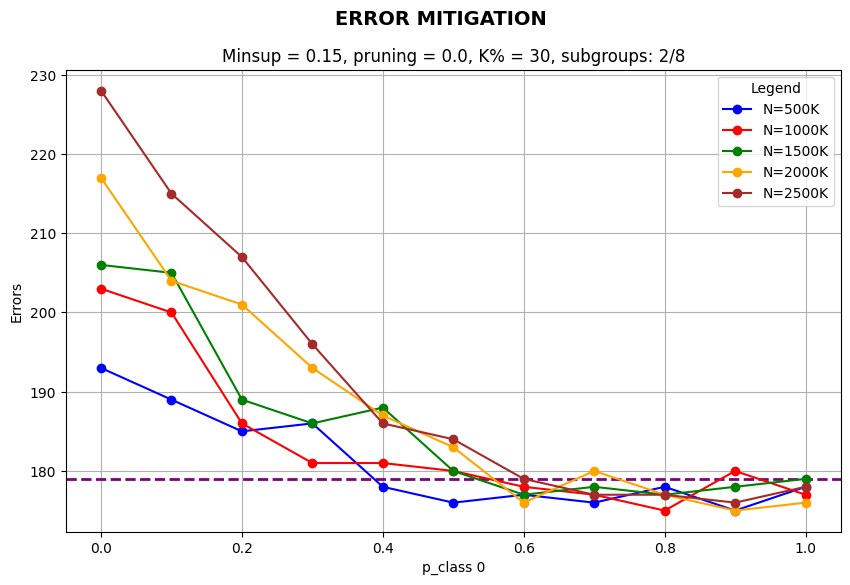

In [42]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Nome del file JSON
json_filename = "error_K_compas.json"

# Caricare i dati dal file JSON
with open(json_filename, "r") as f:
    error_data = json.load(f)

# Estrarre parametri dal JSON
run6_params = error_data.get("run6_parameters", {})
min_sup = run6_params.get("min_sup", "N/A")
percentage = run6_params.get("percentage", "N/A")
th_redundancy = run6_params.get("th_redundancy", "N/A")
L = run6_params.get("L", "N/A")
K = int((percentage / 100) * L) if isinstance(percentage, (int, float)) and isinstance(L, int) else "N/A"

# Lista dei valori di p da 0.0 a 1.0 con step 0.1
p_values = np.round(np.arange(0.0, 1.05, 0.1), 2)

# Definiamo i colori per ogni N
colors = ["blue", "red", "green", "orange", "brown"]
labels = [f"N={n}K" for n in range(500, 2501, 500)]

# Creazione della figura
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("ERROR MITIGATION", fontsize=14, fontweight="bold")

# Disegniamo la linea tratteggiata "Before Mitigation"
before_mitigation_values = [
    error_data.get(f"N={n}K_run6", {}).get("Before Mitigation", None) for n in range(1, 6)
]
before_mitigation_values = [val for val in before_mitigation_values if val is not None]

# Se esistono valori di "Before Mitigation", tracciamo una linea media
if before_mitigation_values:
    avg_before_mitigation = np.mean(before_mitigation_values)
    ax.axhline(y=avg_before_mitigation, color="purple", linestyle="--", linewidth=2, label="Before Mitigation")

# Loop sui vari N (da 1K a 5K)
legend_handles = []
for i, n in enumerate(range(1, 6)):
    N_key = f"N={n}K_run6"
    if N_key not in error_data:
        continue

    data = error_data[N_key]

    # Estrarre i valori di errore
    error_filtered = []
    p_values_filtered = []
    
    for p in p_values:
        key = f"After SMOTE N = {n}K000 p_class 0 = {p}"  # 🛠️ CORRETTA FORMATT.
        if key in data:
            error_filtered.append(data[key])
            p_values_filtered.append(p)

    # Se ci sono dati validi, plottiamo la linea corrispondente
    if error_filtered:
        line, = ax.plot(
            p_values_filtered, error_filtered, 
            marker="o", linestyle="-", color=colors[i], label=labels[i]
        )
        legend_handles.append(line)

# Impostazioni asse
ax.set_title(f"Minsup = {min_sup}, pruning = {th_redundancy}, K% = {percentage}, subgroups: {K}/{L}")
ax.set_xlabel("p_class 0")
ax.set_ylabel("Errors")
ax.grid()

# Aggiungere la leggenda
ax.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True, title="Legend")

# Mostra il grafico
plt.show()
